In [4]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API

from PIL import Image

In [2]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

print('Device Name:', device_product_line)
for s in device.sensors:
    print(s)

Device Name: D400
<pyrealsense2.sensor: "Stereo Module">
<pyrealsense2.sensor: "RGB Camera">
<pyrealsense2.sensor: "Motion Module">


In [3]:
# Start streaming
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
profile = pipeline.start(config)

# Capture frames
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()
depth_frame = frames.get_depth_frame()

# Stop streaming
pipeline.stop()

RuntimeError: Couldn't resolve requests

In [4]:
# Convert images to numpy arrays
color_image = np.asanyarray(color_frame.get_data())[:,:,::-1] # images are stored as BGR instead of RGB
depth_image = np.asanyarray(depth_frame.get_data()) # values are in millimeters

print('Color image shape:', color_image.shape)
print('Depth image shape:', depth_image.shape)

Color image shape: (720, 1280, 3)
Depth image shape: (720, 1280)


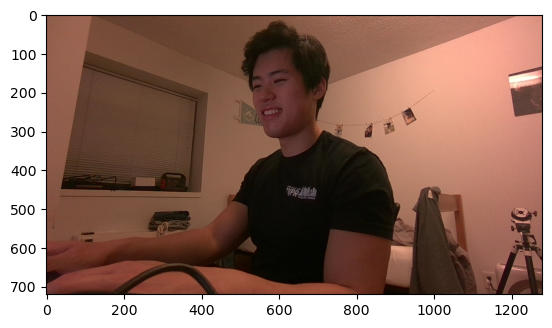

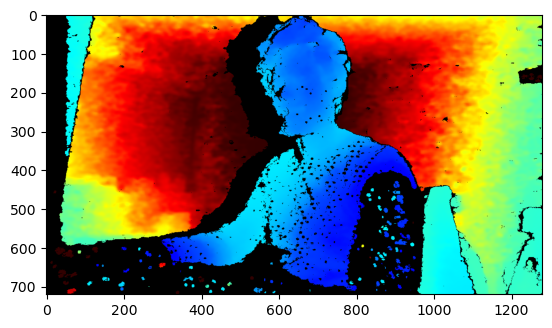

In [5]:
plt.imshow(color_image)
plt.show()

colorizer = rs.colorizer()
colorized_depth_image = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth_image)
plt.show()

# Save Images
#pil_color = Image.fromarray(color_image, 'RGB')
#pil_depth = Image.fromarray(colorized_depth_image, 'RGB')
#pil_color.save('uris_color.png', 'PNG')
#pil_depth.save('uris_depth.png', 'PNG')

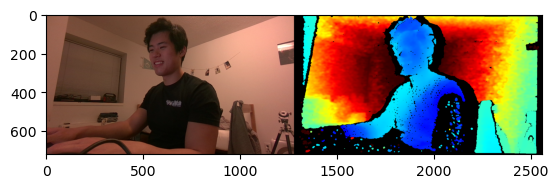

In [6]:
'''
Stream Alignment:

Upon closer inspection you can notice that the two frames are not captured from the same physical viewport.
To combine them into a single RGBD image, let's align depth data to color viewport:
'''

# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frames = align.process(frames)

# Update color and depth frames:
aligned_depth_frame = frames.get_depth_frame()
colorized_depth_image = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color_image, colorized_depth_image))
plt.imshow(images)

## Object Detection

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and use additional
depth data to enrich our prediction.

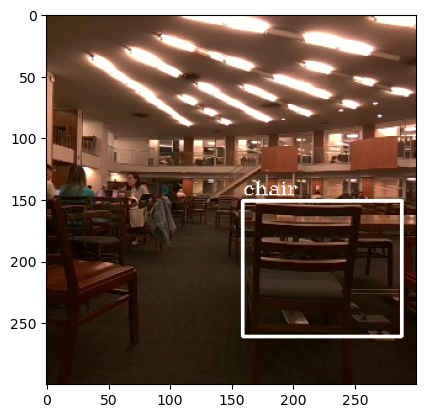

In [28]:
'''
Object Detection:

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and 
use additional depth data to enrich our prediction.
'''

# Standard OpenCV boilerplate for running the net:
height, width = color_image.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color_image, (round(expected * aspect), expected)) # Need to convert back to BGR??
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("./MobileNetSSD/MobileNetSSD_deploy.prototxt", "./MobileNetSSD/MobileNetSSD_deploy.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

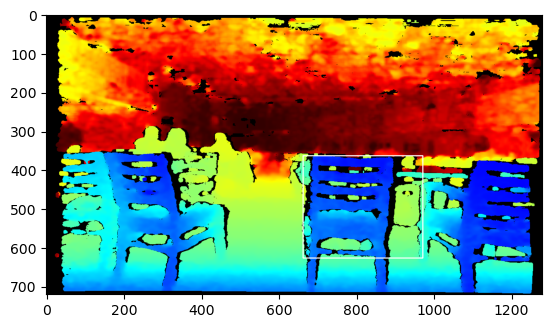

In [29]:
'''
By projecting this data into the depth channel, we can now answer additional questions we couldn't approach before.

For example, with computer vision only it would be rather hard to make any meaningful predictions about **size and distance.
You could train a model on average dog size per breed, but it would be easily fooled by toys of dogs or dogs of irregular proportions. 
Instead you can get this information directly when you have depth available!

Let's project our detected bounding box on to the depth image, and average the depth data inside it to get a sense of how close
is the object:
'''

scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth_image, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth_image)

In [30]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)
# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist = np.median(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

Detected a chair 1.64 meters away.
